In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-medical-flashcards/dataset_dict.json
/kaggle/input/nlp-medical-flashcards/train/state.json
/kaggle/input/nlp-medical-flashcards/train/dataset_info.json
/kaggle/input/nlp-medical-flashcards/train/data-00000-of-00001.arrow


In [2]:
from datasets import Dataset
from gensim.models import Word2Vec


dataset = Dataset.from_file('/kaggle/input/nlp-medical-flashcards/train/data-00000-of-00001.arrow')

df = dataset.to_pandas()

questions = df['input']
answers = df['output']

                            
print("Dataset Description:")
print(df.head()) 


Dataset Description:
                                               input  \
0  What is the relationship between very low Mg2+...   
1  What leads to genitourinary syndrome of menopa...   
2  What does low REM sleep latency and experienci...   
3  What are some possible causes of low PTH and h...   
4  How does the level of anti-müllerian hormone r...   

                                              output  \
0  Very low Mg2+ levels correspond to low PTH lev...   
1  Low estradiol production leads to genitourinar...   
2  Low REM sleep latency and experiencing halluci...   
3  PTH-independent hypercalcemia, which can be ca...   
4  The level of anti-müllerian hormone is directl...   

                       instruction  
0  Answer this question truthfully  
1  Answer this question truthfully  
2  Answer this question truthfully  
3  Answer this question truthfully  
4  Answer this question truthfully  


In [3]:
from sklearn.feature_extraction.text import CountVectorizer

q_and_a = df['input'] + df['output']
print(q_and_a)

vectorizer = CountVectorizer(stop_words='english',min_df=5,max_df=.5)
vector_documents_train = vectorizer.fit_transform(q_and_a)

vocab = vectorizer.get_feature_names_out()
len(vocab)

0        What is the relationship between very low Mg2+...
1        What leads to genitourinary syndrome of menopa...
2        What does low REM sleep latency and experienci...
3        What are some possible causes of low PTH and h...
4        How does the level of anti-müllerian hormone r...
                               ...                        
33950    At what age does bed wetting (enuresis) become...
33951                                                     
33952                                                     
33953                                                     
33954                                                     
Length: 33955, dtype: object


10953

In [4]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=30, verbose=1, learning_method='online', max_iter=30)
lda.fit(vector_documents_train)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


LatentDirichletAllocation(learning_method='online', max_iter=30,
                          n_components=30, verbose=1)

In [5]:
import numpy as np

for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(vocab[i] for i in sorted_terms[:10]) + ']'
    print (f'Topic {i + 1}:\t', concatenated_terms)

Topic 1:	 [immune, primary, non, factor, receptors, body, form, response, does, primarily]
Topic 2:	 [acute, lung, respiratory, lungs, volume, pulmonary, chest, breathing, oxygen, air]
Topic 3:	 [cells, liver, bone, blood, cell, body, type, role, proteins, produce]
Topic 4:	 [patients, treatment, recommended, healthcare, important, therapy, help, reduce, patient, failure]
Topic 5:	 [syndrome, tumors, elevated, features, clinical, managing, shock, characterized, benign, condition]
Topic 6:	 [risk, increased, disorder, individuals, increase, associated, genetic, developing, condition, disorders]
Topic 7:	 [present, typically, presents, age, diagnosis, patient, lymphoma, child, leukemia, mass]
Topic 8:	 [enzyme, activity, step, process, role, seizures, important, sleep, including, nervous]
Topic 9:	 [protein, mechanism, cell, phase, cycle, binding, involved, metabolic, synthesis, does]
Topic 10:	 [effect, characterized, characteristic, receptor, specific, known, type, information, associa

In [6]:
doc = questions[1789]

doc_vec = vectorizer.transform([doc])[0]
topic_vec = lda.transform(doc_vec)[0]

print(doc)
print(df['output'][1789])

sorted_topics = topic_vec.argsort()[::-1]
sorted_prevalence = sorted(topic_vec)[::-1]

for i in range(10):
    if sorted_prevalence[i] < .01: break
    topic = sorted_topics[i]
    sorted_terms = np.flip(lda.components_[topic].argsort())
    print (f'{100 * sorted_prevalence[i]:.1f}% Topic {topic}: {" ".join(vocab[i] for i in sorted_terms[:10])}')

What is dialysis-associated amyloidosis and what does it result in?
Dialysis-associated amyloidosis is characterized by deposition of β2-microglobulin in joints.
67.2% Topic 14: associated common left adults alcohol use condition defect cardiomyopathy systemic
17.2% Topic 20: occur normal result complication occurs time cause damage necrosis glands


In [16]:
from sklearn.manifold import TSNE

tsne_embedding = TSNE(n_components=2).fit_transform(lda.transform(vector_documents_train))
tsne_embedding.shape

(33955, 2)

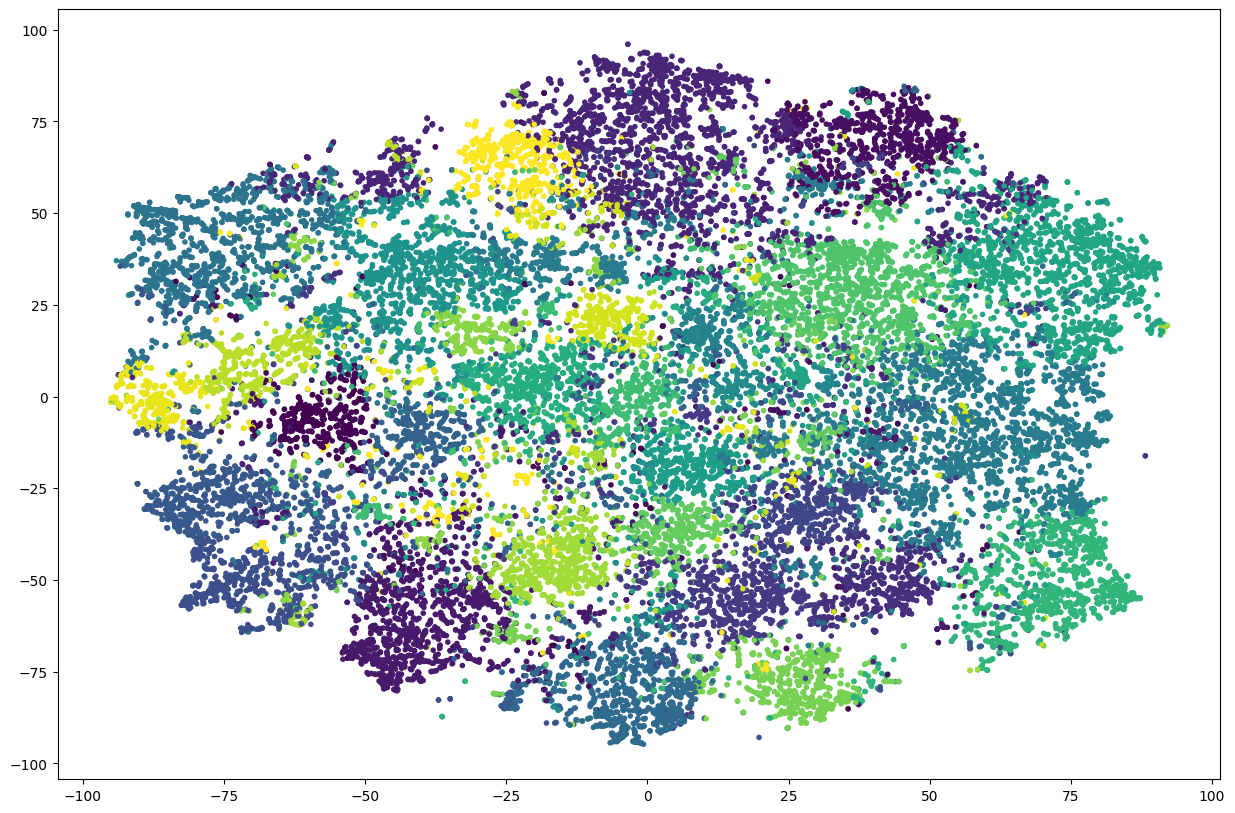

In [21]:
from matplotlib import pyplot as plt

[x, y] = np.transpose(tsne_embedding)

freq_topic = [topic_vec.argsort()[-1] for topic_vec in lda.transform(vector_documents_train)]

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.scatter(x, y, c=freq_topic, marker='.')

In [12]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 58.7 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 9.7 MB/s eta 0:00:00
Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=819466 sha256=ebc03451c02adfdac2367823f5a8babdc106594312ac65aeadfdf9d5170b7997
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cyth

In [15]:
from bertopic import BERTopic
bert_topic_model = BERTopic()
topics, probs = bert_topic_model.fit_transform(q_and_a)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already b

In [ ]:
bert_topic_model.get_topic_info()